### https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en/code

In [109]:
import librosa
import librosa.display
import os
import re
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import kerastuner as kt
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.metrics import make_scorer, accuracy_score

# to play the audio files
from IPython.display import Audio

#import deep learning libraries
import keras
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import Adam
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [2]:
#function that return a list containing a tuple of the emotion and the file path of the given dataset
def emotion_extraction(dataset_path,dataset_name):
    
    emotion_file_list=[]
    
    for root, dirs, files in os.walk(dataset_path):
        
           for filename in files:
                
                File_path= os.path.join(root, filename)
                string=filename.partition(".wav")[0]
                emotion = re.split(r'[-_]',string)
                
                if dataset_name=="Savee_dataset":
                    
                    if len(emotion[1])==4:
                        
                        emotion=emotion[1][0:2]
                        
                    else:
                        
                        emotion=emotion[1][0]
                           
                    emotion_file_list.append((emotion,File_path))
                    
                else:
                    
                    emotion = emotion[2]
                    emotion_file_list.append((emotion,File_path))
            
       
            
    return emotion_file_list

In [3]:
# a function that returns the same dataset of a given one but with another column containing the label of the emotions
def label_construction(dataset):
    
    conditions = [

    (dataset['Emotion']=='neutral'),

    (dataset['Emotion']=='happy'),
    
    (dataset['Emotion']=='sad'),
    
    (dataset['Emotion']=='angry'),
    
    (dataset['Emotion']=='fear'),
    
    (dataset['Emotion']=='disgust'),
    
    (dataset['Emotion']=='surprise')
    ]
    
    labels = [1,2,3,4,5,6,7]
    dataset['Label'] = np.select(conditions, labels)

    
    return dataset

In [4]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

def time_stretch(signal, time_stretch_rate):
    return librosa.effects.time_stretch(signal, time_stretch_rate)


def pitch_scale(signal, sr, num_semitones):
    return librosa.effects.pitch_shift(signal, sr, num_semitones)


def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal


def invert_polarity(signal):
    return signal * -1

In [5]:
def extract_features(signal,sr):
    
    #audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=signal,sr=sr,n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    
    #zero
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal,frame_length=2048,hop_length=512).T, axis=0)
    result = np.hstack((mfccs_processed, zcr))
    
     # Chroma_stft
    stft = np.abs(librosa.stft(signal))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft,sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft))
    
     # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=signal,frame_length=2048,hop_length=512).T, axis=0)
    result = np.hstack((result, rms))
    
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=signal).T, axis=0)
    result = np.hstack((result, mel))
    
    
    return result

In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [13]:
#creating Ravdess dataset
Ravdess_path="C:/Users/noora/Desktop/Data_lebanon/data_nour/15_datascienceprojects\Projects_Intermediate/1_Speech Recognition through the Emotions/Ravdess"

Ravdess_emotion_file_list=emotion_extraction(Ravdess_path,"Ravdess_dataset")

Ravdess_df=pd.DataFrame.from_dict(Ravdess_emotion_file_list)        
Ravdess_df.rename(columns={0:'Label',1:'File_Path'},inplace=True)
Ravdess_df['Label']=Ravdess_df['Label'].astype(int)
Ravdess_df['Emotion']=Ravdess_df['Label'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Ravdess_df['Label'].replace({2:1,3:2,4:3,5:4,6:5,7:6,8:7},inplace=True)
Ravdess_df['Label'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [14]:
Ravdess_df['Emotion'].unique()

array(['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise'],
      dtype=object)

In [15]:
Ravdess_df.head()

,Label,File_Path,Emotion
0,1,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,neutral
1,1,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,neutral
2,1,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,neutral
3,1,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,neutral
4,1,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,neutral


In [16]:
Ravdess_df.shape

(1440, 3)

In [18]:
#creating Crema dataset
Crema_path="C:/Users/noora/Desktop/Data_lebanon/data_nour/15_datascienceprojects\Projects_Intermediate/1_Speech Recognition through the Emotions/Crema/"

Crema_emotion_file_list=emotion_extraction(Crema_path,"Crema_dataset")

Crema_df=pd.DataFrame.from_dict(Crema_emotion_file_list)        
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df['Emotion'].replace({'NEU':'neutral', 'HAP':'happy', 'SAD':'sad', 'ANG':'angry', 'FEA':'fear', 'DIS':'disgust'},inplace=True)
Crema_df['Emotion'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [19]:
Crema_df=label_construction(Crema_df)

In [20]:
Crema_df['Label'].unique()

array([4, 6, 5, 2, 1, 3])

In [21]:
Crema_df.head()

,Emotion,File_Path,Label
0,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4
1,disgust,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,6
2,fear,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,5
3,happy,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,2
4,neutral,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,1


In [22]:
Crema_df.shape

(7442, 3)

In [24]:
#creating Tess dataset
Tess_path="C:/Users/noora/Desktop/Data_lebanon/data_nour/15_datascienceprojects\Projects_Intermediate/1_Speech Recognition through the Emotions/Tess/"

Tess_emotion_file_list=emotion_extraction(Tess_path,"Tess_dataset")

Tess_df=pd.DataFrame.from_dict(Tess_emotion_file_list)        
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df['Emotion'].replace({'ps':'surprise'},inplace=True)
Tess_df['Emotion'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'surprise', 'sad'],
      dtype=object)

In [25]:
Tess_df=label_construction(Tess_df)

In [26]:
Tess_df['Label'].unique()

array([4, 6, 5, 2, 1, 7, 3])

In [27]:
Tess_df.head()

,Emotion,File_Path,Label
0,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4
1,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4
2,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4
3,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4
4,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4


In [28]:
Tess_df.shape

(2800, 3)

In [31]:
#creating Save dataset
Savee_path="C:/Users/noora/Desktop/Data_lebanon/data_nour/15_datascienceprojects\Projects_Intermediate/1_Speech Recognition through the Emotions/Savee/"

Savee_emotion_file_list=emotion_extraction(Savee_path,"Savee_dataset")

Savee_df=pd.DataFrame.from_dict(Savee_emotion_file_list)        
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df['Emotion'].replace({'a':'angry','d':'disgust','f':'fear','h':'happy','n':'neutral','sa':'sad','su':'surprise'},inplace=True)
Savee_df['Emotion'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [32]:
Savee_df=label_construction(Savee_df)

In [33]:
Savee_df['Label'].unique()

array([4, 6, 5, 2, 1, 3, 7])

In [34]:
Savee_df.head()

,Emotion,File_Path,Label
0,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4
1,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4
2,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4
3,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4
4,angry,C:/Users/noora/Desktop/Data_lebanon/data_nour/...,4


In [35]:
Savee_df.shape

(480, 3)

In [36]:
#Concatenating the 4 datasets
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df],axis=0)
main_df.shape

(12162, 3)

In [37]:
# Make sure of the emptiness of the nan values
main_df.isna().sum()

Emotion      0
File_Path    0
Label        0
dtype: int64

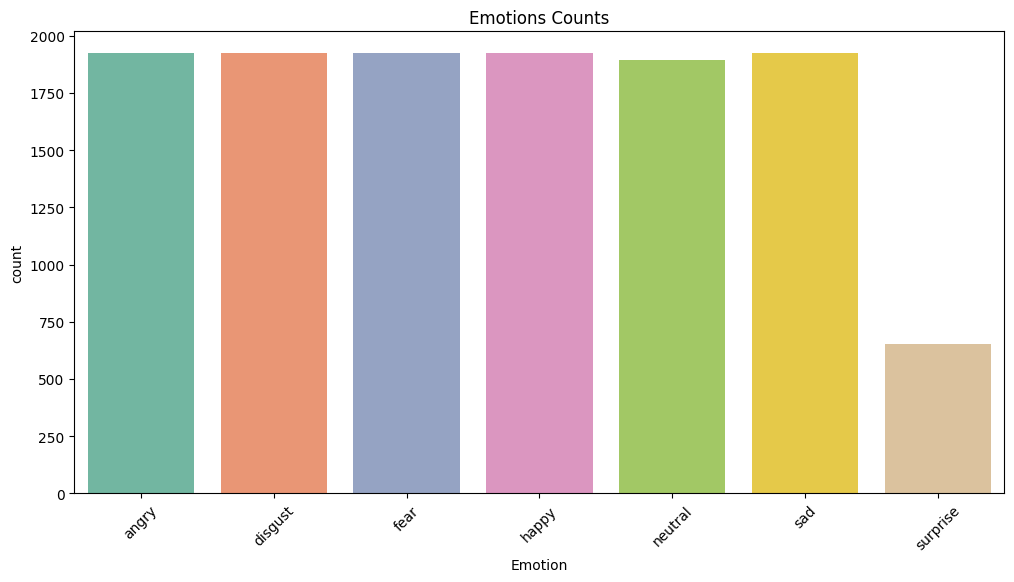

In [38]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

In [39]:
#Let's evaluate the data augmentation in a test audio file
a=main_df['File_Path'][0]
a=a.tolist()[0]

In [40]:
a

'C:/Users/noora/Desktop/Data_lebanon/data_nour/15_datascienceprojects\\Projects_Intermediate/1_Speech Recognition through the Emotions/Crema/1001_DFA_ANG_XX.wav'

In [41]:
# original audio without augmentation
signal, sample_rate = librosa.load(a,duration=2.5,offset=0.6) 
original_features = extract_features(signal,sample_rate)

In [42]:
original_features

array([-3.36036133e+02,  1.28549423e+02, -2.10259876e+01,  4.72950554e+01,
       -5.41748381e+00,  1.92820969e+01, -2.31845779e+01, -5.40723419e+00,
       -9.08686256e+00, -3.74869204e+00, -9.23443031e+00, -5.34765673e+00,
        3.10877532e-01, -1.73296833e+01,  1.06858721e+01, -1.35036926e+01,
       -7.30754375e+00, -1.50612330e+00, -3.38277173e+00, -6.68879080e+00,
       -8.79418850e+00, -2.31116223e+00, -1.03494062e+01, -1.72528505e+00,
       -5.37211180e+00,  2.07520342e+00, -3.87447000e+00, -2.14213896e+00,
       -2.80097216e-01, -4.33491325e+00,  7.20507443e-01, -3.64516997e+00,
        7.65401006e-01, -4.08963919e+00, -3.83649898e+00, -5.53346252e+00,
       -4.12660217e+00, -2.96473002e+00, -4.01088572e+00, -1.67081046e+00,
        8.38372217e-02,  6.77546084e-01,  7.00793028e-01,  6.78331971e-01,
        6.80872858e-01,  6.79725230e-01,  5.84707558e-01,  5.83746791e-01,
        6.52854264e-01,  6.56524897e-01,  7.30741441e-01,  8.13153803e-01,
        7.67077684e-01,  

In [43]:
original_features.shape

(182,)

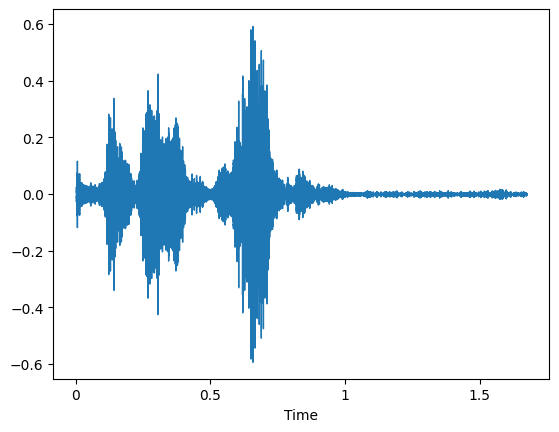

In [44]:
librosa.display.waveshow(signal,sr=sample_rate)
Audio(signal,rate=sample_rate)

In [45]:
# data with noise
noise_data = add_white_noise(signal,0.35)
feature_noise = extract_features(noise_data,sample_rate)

In [46]:
feature_noise

array([-1.47884011e+02,  2.51555333e+01,  2.68850648e+00,  7.07997454e+00,
        7.19538467e+00, -6.91296624e-01, -7.42023050e+00, -9.46068002e+00,
       -4.23716298e+00, -2.72891421e+00, -3.97327415e+00, -1.46598555e+00,
       -3.41803741e+00, -3.40675893e+00,  6.79213204e-01, -3.35945682e+00,
       -5.47144208e+00, -1.33289594e+00, -1.53407579e+00, -4.67028254e+00,
       -4.41759019e+00, -3.47604092e+00, -3.99016296e+00, -2.50032867e+00,
       -9.92012287e-01,  2.71412518e-02, -8.36012388e-01, -7.67688134e-01,
        8.48140126e-01,  4.49848467e-01, -1.15565040e-01,  3.26430489e-01,
       -1.99752892e-01, -1.12802174e+00, -2.73787612e+00, -3.11003463e+00,
       -2.71743483e+00, -1.53065660e+00, -2.58290068e+00, -1.72726152e+00,
        3.46973994e-01,  8.07648196e-01,  7.84924956e-01,  8.21898844e-01,
        8.36177888e-01,  8.65963423e-01,  7.44275150e-01,  6.51705636e-01,
        7.13863362e-01,  7.20331812e-01,  7.47841573e-01,  8.17215333e-01,
        8.57731173e-01,  

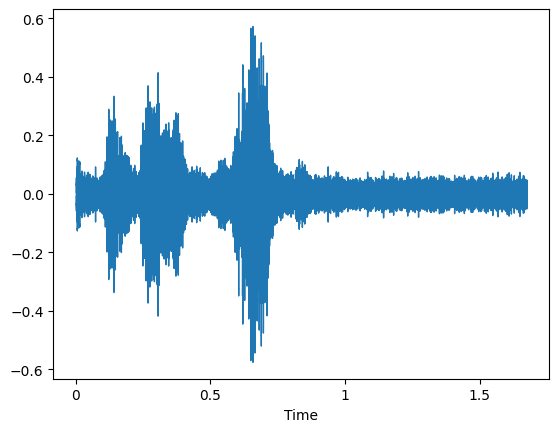

In [47]:
librosa.display.waveshow(noise_data,sr=sample_rate)
Audio(noise_data,rate=sample_rate)

In [48]:
# data with stretching and pitching
data_stretch = time_stretch(signal,0.8)
data_stretch_pitch = pitch_scale(data_stretch,sample_rate,2)
feature_stretch_pitch = extract_features(data_stretch_pitch,sample_rate)

In [49]:
feature_stretch_pitch

array([-3.93578217e+02,  1.13298538e+02, -1.96871204e+01,  4.31455956e+01,
       -9.53276348e+00,  1.03223619e+01, -3.16017933e+01,  2.24222112e+00,
       -1.26585140e+01,  9.32212889e-01, -1.42197533e+01,  5.08707094e+00,
       -1.49015818e+01, -4.76565510e-01, -2.59985685e+00, -1.60606441e+01,
        4.19231701e+00, -8.45229340e+00, -5.41366577e+00, -1.10545235e+01,
       -4.05864507e-01, -9.59335136e+00,  1.14098275e+00, -3.41667819e+00,
        6.86409175e-01, -4.49918127e+00, -2.38302469e+00, -2.37275928e-01,
       -2.80622053e+00,  4.00657207e-01, -5.86175013e+00, -1.86598861e+00,
       -7.46072197e+00, -2.48704100e+00, -3.56109619e+00,  4.35349107e-01,
       -1.56810999e+00,  8.16574454e-01,  1.48031175e+00,  1.94226694e+00,
        9.48016827e-02,  7.46974826e-01,  7.45479524e-01,  6.60902321e-01,
        6.79809630e-01,  6.62397981e-01,  6.59110665e-01,  6.70980871e-01,
        5.68400860e-01,  5.78816652e-01,  6.57212913e-01,  6.53483570e-01,
        6.89595878e-01,  

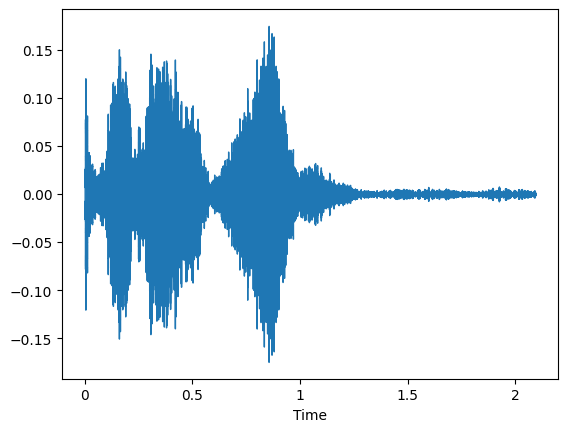

In [50]:
librosa.display.waveshow(data_stretch_pitch,sr=sample_rate)
Audio(data_stretch_pitch,rate=sample_rate)

In [51]:
# data with random_gain and invert_polarity
random_data_gain=random_gain(signal)
data_invert_gain=invert_polarity(random_data_gain)
feature_invert_gain = extract_features(data_invert_gain,sample_rate)

In [52]:
feature_invert_gain

array([-5.56570801e+02,  1.28549423e+02, -2.10259914e+01,  4.72950554e+01,
       -5.41748714e+00,  1.92820969e+01, -2.31845779e+01, -5.40723467e+00,
       -9.08686447e+00, -3.74869156e+00, -9.23442936e+00, -5.34765768e+00,
        3.10878873e-01, -1.73296833e+01,  1.06858730e+01, -1.35036926e+01,
       -7.30754280e+00, -1.50612366e+00, -3.38277316e+00, -6.68879032e+00,
       -8.79419041e+00, -2.31116152e+00, -1.03494062e+01, -1.72528517e+00,
       -5.37211180e+00,  2.07520318e+00, -3.87447000e+00, -2.14213896e+00,
       -2.80098945e-01, -4.33491325e+00,  7.20507741e-01, -3.64516950e+00,
        7.65402138e-01, -4.08963966e+00, -3.83649969e+00, -5.53346252e+00,
       -4.12660170e+00, -2.96473050e+00, -4.01088381e+00, -1.67080986e+00,
        8.38505993e-02,  6.77546144e-01,  7.00793028e-01,  6.78332031e-01,
        6.80872858e-01,  6.79725289e-01,  5.84707499e-01,  5.83746791e-01,
        6.52854204e-01,  6.56524837e-01,  7.30741262e-01,  8.13153803e-01,
        7.67077625e-01,  

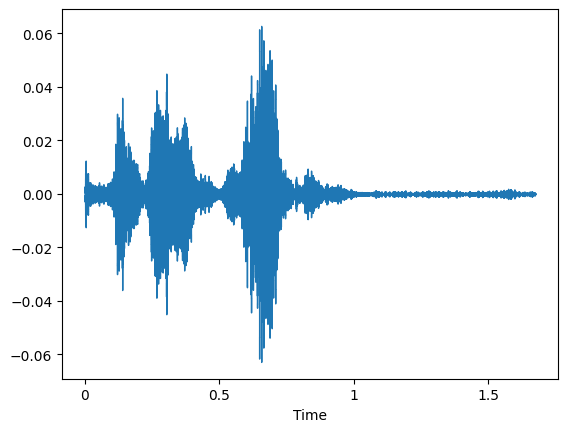

In [53]:
librosa.display.waveshow(data_invert_gain,sr=sample_rate)
Audio(data_invert_gain,rate=sample_rate)

In [54]:
features=[]

# Iterate through each sound file and extract the features 
for index, row in main_df.iterrows():
    
    file_name=row["File_Path"]
    class_label = row["Emotion"]
    
    # original audio without augmentation
    signal, sample_rate = librosa.load(file_name, duration=2.5, offset=0.6) 
    original_feature = extract_features(signal,sample_rate)
    
    # data with noise
    noise_data = add_white_noise(signal,0.35)
    feature_noise = extract_features(noise_data,sample_rate)
    
    # data with stretching and pitching
    data_stretch = time_stretch(signal,0.8)
    data_stretch_pitch = pitch_scale(data_stretch,sample_rate,2)
    feature_stretch_pitch = extract_features(data_stretch_pitch,sample_rate)
    
    
    # data with random_gain and invert_polarity
    random_data_gain=random_gain(signal)
    data_invert_gain=invert_polarity(random_data_gain)
    feature_invert_gain = extract_features(data_invert_gain,sample_rate)
    
    
    #append all the new data into the features list
    features.append([original_feature,class_label])
    features.append([feature_noise,class_label])
    features.append([feature_stretch_pitch,class_label])
    features.append([feature_invert_gain,class_label])

# Convert the features list into a Panda dataframe 
features_df = pd.DataFrame(features, columns=['feature','class_label'])

In [55]:
# print the feature data frame
features_df

,feature,class_label
0,"[-336.0361328125, 128.54942321777344, -21.0259...",angry
1,"[-148.7997523920053, 24.441148366545693, 3.080...",angry
2,"[-393.5782165527344, 113.29853820800781, -19.6...",angry
3,"[-556.46533203125, 128.54942321777344, -21.025...",angry
4,"[-367.8321533203125, 138.78517150878906, -27.3...",disgust
...,...,...
48643,"[-666.9138793945312, 95.18640899658203, 26.987...",sad
48644,"[-429.60675048828125, 76.13542175292969, 30.69...",sad
48645,"[-209.97533675331425, 16.557705600051325, 14.5...",sad
48646,"[-497.52587890625, 72.36127471923828, 35.12197...",sad


In [56]:
features_df.iloc[0]['feature'].shape

(182,)

In [57]:
# shuffle the main data 
shuffled = features_df.sample(frac=1)

In [112]:
shuffled

,feature,class_label
6178,"[-513.0548095703125, 135.69834899902344, 21.88...",sad
8932,"[-418.9959411621094, 139.67355346679688, 11.42...",neutral
15216,"[-407.7387390136719, 146.38893127441406, 6.090...",sad
29860,"[-652.4600219726562, 81.92184448242188, -1.465...",sad
11913,"[-301.22505488173914, 46.02328521431144, 34.20...",sad
...,...,...
17346,"[-430.6878356933594, 130.28933715820312, 4.295...",disgust
38832,"[-438.33868408203125, 81.6550521850586, 19.273...",disgust
36026,"[-237.96539306640625, 98.02543640136719, -7.18...",angry
1244,"[-394.9978942871094, 135.27525329589844, -22.8...",fear


In [59]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(shuffled.feature.tolist())
y = np.array(shuffled.class_label.tolist())

In [60]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = y
extracted_df.to_csv('features', index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,labels
0,-513.054810,135.698349,21.885513,59.864048,-4.044246,16.613415,-22.914700,13.724521,-12.897847,9.434447,-10.621277,3.873516,-3.405404,-2.702754,-3.017185,-6.210899,3.277802,-12.000345,-2.563038,-7.079415,8.122742,-3.714324,2.996236,-2.336322,0.992236,-2.464169,0.146180,3.568362,4.846335,7.577524,3.251439,8.350565,-1.393678,3.464251,-1.213294,0.389465,-5.446881,-0.899161,-1.222118,-0.487849,0.042072,0.744956,0.498764,0.467254,0.594016,0.597693,0.524136,0.483888,0.496607,0.443751,0.535097,0.653203,0.787791,0.004961,0.019359,0.011088,0.008128,0.011062,0.024718,0.015564,0.026492,0.036238,0.140014,0.142423,0.016187,0.032157,0.024153,0.003371,0.003257,0.012586,0.055828,0.116678,0.040913,0.008823,0.004374,0.004263,0.009408,0.031556,0.052143,0.106336,0.011646,0.007727,0.002093,0.000462,0.000282,0.000266,0.000889,0.001448,0.001785,0.000399,0.000157,0.000408,0.000180,0.000111,0.000075,0.000046,0.000021,0.000028,0.000024,0.000046,0.000067,0.000056,0.000036,0.000037,0.000062,0.000056,0.000076,0.000112,0.000113,0.000047,0.000025,0.000017,0.000128,0.000331,0.000104,0.000047,0.000118,0.000303,0.000493,0.000228,0.000187,0.000269,0.000124,0.000032,0.000024,0.000045,0.000050,0.000091,0.000045,0.000066,0.000035,0.000044,0.000051,0.000078,0.000063,0.000118,0.000100,0.000069,0.000060,0.000020,0.000026,0.000060,0.000081,0.000035,0.000050,0.000032,0.000030,0.000012,0.000009,0.000011,0.000011,0.000014,0.000010,0.000010,0.000005,0.000005,0.000006,0.000005,0.000004,0.000004,0.000006,0.000006,0.000008,0.000006,0.000007,0.000008,0.000008,0.000009,0.000010,1.067623e-05,5.576340e-06,2.565955e-06,2.895211e-07,7.931857e-09,4.722293e-10,4.018979e-10,3.954077e-10,3.363177e-10,2.844294e-10,1.945623e-10,1.296665e-10,9.912340e-11,sad
1,-418.995941,139.673553,11.426174,68.100479,-15.907581,24.526400,-14.717821,10.917768,-9.944403,-0.048804,1.914845,-10.547445,6.540686,-11.366655,4.855863,-11.353030,2.495052,-6.605262,-3.782898,0.563691,-8.907384,1.769439,-4.176246,2.765658,-4.821094,2.902541,-1.715220,3.502462,4.508622,-1.231075,2.754452,-4.107624,5.371284,-0.301074,2.759292,2.653302,4.112117,2.890252,-1.513948,2.463191,0.053927,0.531837,0.576460,0.578043,0.519697,0.531088,0.555115,0.602606,0.648936,0.657819,0.691064,0.611897,0.502620,0.013304,0.124287,0.044696,0.043633,0.056534,0.123316,0.270747,0.622850,0.811176,0.565494,0.157052,0.313382,0.255094,0.137829,0.170676,0.421694,0.943594,0.192996,0.401574,0.147647,0.091815,0.329663,0.108988,0.062914,0.015608,0.005519,0.008796,0.020346,0.083284,0.118602,0.043335,0.034238,0.017379,0.010597,0.004804,0.008660,0.021587,0.019925,0.028260,0.013975,0.002898,0.001313,0.000603,0.003993,0.009341,0.006267,0.003040,0.002153,0.001225,0.001810,0.003645,0.001759,0.001191,0.000769,0.000916,0.002090,0.005457,0.002063,0.001642,0.001311,0.000790,0.001112,0.000516,0.001517,0.001496,0.000807,0.000931,0.000555,0.000232,0.000331,0.000292,0.000331,0.000673,0.000782,0.000288,0.000274,0.000440,0.000533,0.000928,0.000993,0.001295,0.001173,0.001174,0.001476,0.000477,0.000585,0.000603,0.000298,0.000288,0.000091,0.000172,0.000174,0.000154,0.000218,0.000223,0.000180,0.000217,0.000182,0.000132,0.000122,0.000086,0.000094,0.000286,0.000425,0.000232,0.000185,0.000280,0.000391,0.000459,0.000405,0.000454,0.000902,0.000953,0.000392,0.000073,0.000005,5.651643e-08,7.421983e-09,6.566204e-09,6.006407e-09,5.588529e-09,5.255676e-09,4.995948e-09,

In [85]:
extracted_df = pd.read_csv('features')
print(extracted_df.shape)

(48648, 183)


In [62]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
178       False
179       False
180       False
181       False
labels    False
Length: 183, dtype: bool


(48648, 183)

In [86]:
X = extracted_df.drop(labels="labels", axis=1)
y = extracted_df["labels"]

In [87]:
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [88]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [89]:
# split the dataset
x_train,x_test,y_train,y_test=train_test_split(X,yy,random_state=42,test_size=0.2,shuffle=True)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,random_state=42,test_size=0.1,shuffle=True)
x_train.shape, x_test.shape, x_val.shape, y_train.shape,y_test.shape,y_val.shape



((35026, 182), (9730, 182), (3892, 182), (35026, 7), (9730, 7), (3892, 7))

In [90]:
b=x_train[0:10]
b

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181
12139,-212.769391,16.147779,1.357878,1.136507,1.211960,-2.970507,-6.951890,-8.229542,-5.774351,-3.224245,-3.152538,-3.672182,-3.208864,-3.200171,-2.962201,-2.057380,-2.477554,-2.279323,-2.178380,-2.604651,-1.701396,0.299662,-0.748498,-0.660761,0.569964,1.196495,2.110409,3.663315,3.190427,2.694909,3.547081,4.692856,3.780817,2.186133,0.026816,-1.486988,-0.624815,0.685105,1.431840,-0.453978,0.325114,0.711678,0.701456,0.743761,0.797059,0.753630,0.615910,0.645962,0.643476,0.718457,0.732857,0.719550,0.723032,0.027440,0.009220,0.009282,0.009234,0.008196,0.008533,0.022910,0.138318,1.090294,1.625029,1.405500,1.290884,2.380162,3.778165,2.720553,0.435655,0.418968,1.978840,1.157325,0.834377,0.397537,0.230261,0.236268,0.265836,0.480737,0.852582,0.569762,0.173736,0.317972,1.635252,0.516595,0.109855,0.081460,0.143032,0.109945,0.092057,0.031996,0.019839,0.271444,0.341340,0.195678,0.054827,0.052600,0.042844,0.016053,0.017109,0.071390,0.230455,0.198064,0.266304,0.159723,0.031330,0.021781,0.033325,0.147127,0.132333,0.083186,0.022069,0.043899,0.218168,0.133928,0.075782,0.035226,0.042850,0.043477,0.033492,0.027149,0.035022,0.027151,0.018546,0.015690,0.021163,0.022461,0.036515,0.032021,0.020914,0.026520,0.018125,0.015054,0.011900,0.011366,0.012936,0.013032,0.013384,0.015908,0.020651,0.014656,0.013942,0.015917,0.012349,0.011855,0.010830,0.009515,0.009528,0.009709,0.010478,0.010445,0.010492,0.010125,0.010357,0.011772,0.010686,0.009884,1.012705e-02,9.769828e-03,0.008956,0.009704,0.010056,0.010362,0.009287,0.008805,0.009565,0.008792,0.008805,0.008798,9.663632e-03,9.234386e-03,8.857530e-03,8.711582e-03,8.782937e-03,9.200660e-03,9.180511e-03,9.788642e-03,9.622932e-03,9.398286e-03,8.928843e-03,8.695857e-03,8.681339e-03,8.850922e-03
6544,-182.474774,31.292647,13.121290,12.633093,8.559724,-1.623722,-8.587589,-7.201708,-3.165334,2.190770,0.879726,-2.513354,-0.641241,-1.301381,-3.183472,-3.056229,-3.472543,-1.168015,0.553504,-0.921880,-2.740471,-1.442689,-0.086979,-1.163326,0.335901,0.800141,-0.475413,-0.248748,0.100909,-0.147793,1.270526,1.569304,0.654269,-0.591165,-2.120666,-3.011682,-3.214720,-2.076957,0.894972,3.047608,0.284668,0.788688,0.723392,0.710168,0.737982,0.863074,0.808740,0.675842,0.689857,0.695042,0.719590,0.691910,0.750653,0.033716,0.105397,0.052857,0.078247,0.152891,0.251886,0.811906,0.574864,0.170061,0.431218,1.171258,0.821833,1.301341,2.296339,1.501842,1.037606,0.233258,0.373672,1.090270,3.727181,3.361463,0.455976,0.421237,0.156641,1.791126,3.672935,4.168524,3.569795,0.461802,0.201053,0.148875,0.502804,0.709196,0.552737,0.126469,0.019126,0.016551,0.015021,0.020582,0.041783,0.051507,0.031385,0.019447,0.015092,0.035855,0.063608,0.022430,0.020858,0.026021,0.028125,0.048765,0.048836,0.027304,0.030492,0.149431,0.153780,0.076579,0.080569,0.251096,0.929632,0.356363,0.110165,0.099401,0.156893,0.072290,0.052027,0.075128,0.035156,0.106141,0.069790,0.030994,0.036526,0.074039,0.038874,0.035856,0.026222,0.018915,0.020828,0.022039,0.025469,0.026881,0.035309,0.037615,0.056695,0.032582,0.042075,0.029441,0.028482,0.016018,0.014637,0.013287,0.013757,0.014548,0.014662,0.013446,0.013179,0.013207,0.013612,0.013285,0.012526,0.012728,0.014406,0.015386,1.560813e-02,1.683864e-02,0.016368,0.015318,0.013808,0.015059,0.014441,0.013999,0.013269,0.012998,0.012947,0.012234,1.287653e-02,1.295079e-02,1.317870e-02,1.319318e-02,1.241777e-02,1.257938e-02,1.231887e-02,1.

In [91]:
b.shape

(10, 182)

In [92]:
e = np.expand_dims(b,-1)
e

array([[[-2.12769391e+02],
        [ 1.61477789e+01],
        [ 1.35787773e+00],
        ...,
        [ 8.69585728e-03],
        [ 8.68133907e-03],
        [ 8.85092181e-03]],

       [[-1.82474774e+02],
        [ 3.12926470e+01],
        [ 1.31212896e+01],
        ...,
        [ 1.21445126e-02],
        [ 1.20668561e-02],
        [ 1.25845548e-02]],

       [[-4.90597076e+02],
        [ 1.26723244e+02],
        [-1.04832258e+01],
        ...,
        [ 1.42518705e-11],
        [ 1.40224577e-11],
        [ 1.38760331e-11]],

       ...,

       [[-3.34108917e+02],
        [ 1.22094109e+02],
        [-3.21130257e+01],
        ...,
        [ 2.88421006e-07],
        [ 2.82551810e-07],
        [ 2.78881032e-07]],

       [[-6.57468079e+02],
        [ 7.16462250e+01],
        [ 2.31594810e+01],
        ...,
        [ 1.50510214e-05],
        [ 1.09261794e-06],
        [ 1.22177068e-08]],

       [[-6.64760925e+02],
        [ 1.47436005e+02],
        [-1.50319023e+01],
        ...,
        

In [93]:
e.shape

(10, 182, 1)

In [94]:
d=y_train[0:10]

In [95]:
d

array([[0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [96]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val=scaler.fit_transform(x_val)

In [97]:
x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

In [98]:
x_train.shape,x_test.shape,x_val.shape,y_train.shape,y_test.shape,y_val.shape

((35026, 182, 1),
 (9730, 182, 1),
 (3892, 182, 1),
 (35026, 7),
 (9730, 7),
 (3892, 7))

In [99]:
input_shape=(x_train[1],1)

In [115]:
def model_builder(hp):
    
    model=keras.Sequential()
    model.add(Conv1D(hp.Int("conv_1",min_value=32,max_value=512,step=32),kernel_size=5,padding='same',strides=1,activation='relu',input_shape=(182,1)))
    model.add(MaxPooling1D(pool_size=1, strides = 2, padding = 'same'))
    
  # second CONV => RELU => POOL layer set
    model.add(Conv1D(hp.Int("conv_2", min_value=64, max_value=256, step=32),strides=1,kernel_size=5,activation='relu',padding="same"))
    model.add(MaxPooling1D(pool_size=1, strides = 2, padding = 'same'))
    
    
     # third CONV => RELU => POOL layer set
    model.add(Conv1D(hp.Int("conv_3", min_value=64, max_value=512, step=32),strides=1,kernel_size=5,activation='relu',padding="same"))
    model.add(MaxPooling1D(pool_size=1, strides = 2, padding = 'same'))
    
    # third CONV => RELU => POOL layer set
    model.add(Conv1D(hp.Int("conv_4", min_value=64, max_value=1024, step=32),strides=1,kernel_size=5,activation='relu',padding="same"))
    model.add(MaxPooling1D(pool_size=1, strides = 2, padding = 'same'))
    
    

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(hp.Int("dense_1", min_value=256,max_value=768, step=256),activation='relu'))
    model.add(Dropout(0.3))
    
     # Second (and only) set of FC => RELU layers
    model.add(Dense(hp.Int("dense_1", min_value=256,max_value=768, step=256), activation='relu'))
    model.add(Dropout(0.3))
    
     # Third (and only) set of FC => RELU layers
    model.add(Dense(hp.Int("dense_1", min_value=256,max_value=768, step=256), activation='relu'))
    model.add(Dropout(0.3))
    
    
    # softmax classifier
    model.add(Dense(7, activation='softmax'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model
    

In [101]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_accuracy', # objective to optimize
                     max_epochs=10,
                     factor=3, # factor which you have seen above 
                     directory='dir', # directory to save logs 
                     project_name='khyperband')

INFO:tensorflow:Reloading Oracle from existing project dir\khyperband\oracle.json
INFO:tensorflow:Reloading Tuner from dir\khyperband\tuner0.json


In [102]:
#hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 5
conv_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
conv_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
conv_3 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': None}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 768, 'step': 256, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [103]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [104]:
best_hp=tuner.get_best_hyperparameters()[0]

In [105]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
h_model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 182, 128)          768       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 91, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 91, 96)            61536     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 46, 96)           0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 46, 64)            30784     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 23, 64)          

In [106]:
h_eval_dict = h_model.evaluate(x_test,y_test, return_dict=True)

305/305 [==============================] - 3s 9ms/step - loss: 1.0018 - accuracy: 0.6237


In [ ]:
# plot accuracy/error for training and validation
plot_history(h_model)

In [ ]:
import tensorflow.keras.layers as L

In [117]:
#model CNN 2
from tensorflow.keras import layers as L  
model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 182, 512)          3072      
                                                                 
 batch_normalization (BatchN  (None, 182, 512)         2048      
 ormalization)                                                   
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 91, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_41 (Conv1D)          (None, 91, 512)           1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 91, 512)          2048      
 hNormalization)                                                 
                                                     

In [118]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=50,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
history=model.fit(x_train, y_train, epochs=10, validation_data=(x_val,y_val), batch_size=64,callbacks=[early_stop,lr_reduction])

Epoch 1/10
548/548 [==============================] - 206s 377ms/step - loss: 1.3076 - accuracy: 0.4893 - val_loss: 1.7524 - val_accuracy: 0.3582 - lr: 0.0010
Epoch 2/10
464/548 [========================>.....] - ETA: 31s - loss: 1.2298 - accuracy: 0.5174

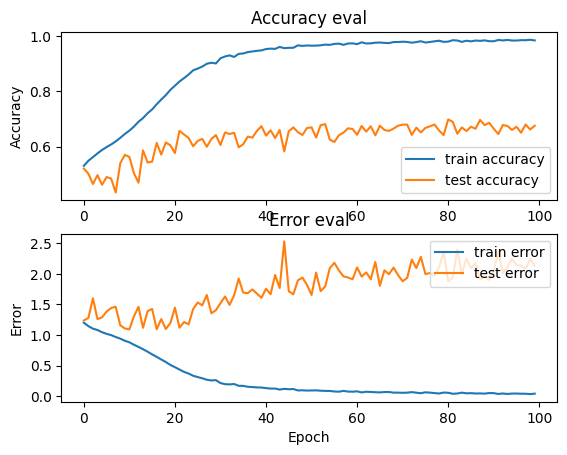

In [72]:
# plot accuracy/error for training and validation
plot_history(history)

In [73]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

305/305 - 3s - loss: 2.1353 - accuracy: 0.6760 - 3s/epoch - 9ms/step

Test accuracy: 0.6759506464004517


In [127]:
#CNN model 3
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [128]:
earlystopping = EarlyStopping(monitor ="val_acc",mode = 'auto', patience = 5,restore_best_weights = True)

In [129]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [131]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=50, batch_size=64,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/50
609/609 [==============================] - 28s 43ms/step - loss: 1.4659 - accuracy: 0.4364 - val_loss: 1.6052 - val_accuracy: 0.4047 - lr: 0.0010
Epoch 2/50
609/609 [==============================] - 26s 43ms/step - loss: 1.2101 - accuracy: 0.5275 - val_loss: 1.4779 - val_accuracy: 0.4798 - lr: 0.0010
Epoch 3/50
609/609 [==============================] - 26s 43ms/step - loss: 1.1276 - accuracy: 0.5611 - val_loss: 1.2710 - val_accuracy: 0.5010 - lr: 0.0010
Epoch 4/50
609/609 [==============================] - 26s 43ms/step - loss: 1.0707 - accuracy: 0.5831 - val_loss: 1.4337 - val_accuracy: 0.4963 - lr: 0.0010
Epoch 5/50
609/609 [==============================] - 26s 43ms/step - loss: 1.0228 - accuracy: 0.6027 - val_loss: 2.5989 - val_accuracy: 0.3459 - lr: 0.0010
Epoch 6/50
609/609 [==============================] - 26s 43ms/step - loss: 0.9764 - accuracy: 0.6179 - val_loss: 1.1716 - val_accuracy: 0.5561 - lr: 0.0010
Epoch 7/50
609/609 [==============================] - 26s 

Epoch 16/50
609/609 [==============================] - 26s 43ms/step - loss: 0.4868 - accuracy: 0.8168 - val_loss: 1.5011 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 17/50
609/609 [==============================] - 27s 44ms/step - loss: 0.4462 - accuracy: 0.8355 - val_loss: 1.5679 - val_accuracy: 0.6231 - lr: 0.0010
Epoch 18/50
609/609 [==============================] - 27s 44ms/step - loss: 0.4072 - accuracy: 0.8495 - val_loss: 1.2292 - val_accuracy: 0.6229 - lr: 0.0010
Epoch 19/50
609/609 [==============================] - 27s 44ms/step - loss: 0.3758 - accuracy: 0.8609 - val_loss: 2.0463 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 20/50
609/609 [==============================] - 27s 44ms/step - loss: 0.3462 - accuracy: 0.8713 - val_loss: 1.4727 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 21/50
609/609 [==============================] - 26s 43ms/step - loss: 0.3225 - accuracy: 0.8808 - val_loss: 2.5716 - val_accuracy: 0.5427 - lr: 0.0010
Epoch 22/50
609/609 [==============================]

Epoch 31/50
609/609 [==============================] - 26s 43ms/step - loss: 0.1745 - accuracy: 0.9389 - val_loss: 1.9767 - val_accuracy: 0.6544 - lr: 0.0010
Epoch 32/50
609/609 [==============================] - 26s 43ms/step - loss: 0.1711 - accuracy: 0.9399 - val_loss: 1.3510 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 33/50
609/609 [==============================] - 26s 43ms/step - loss: 0.1603 - accuracy: 0.9434 - val_loss: 1.6472 - val_accuracy: 0.6816 - lr: 0.0010
Epoch 34/50
609/609 [==============================] - 26s 43ms/step - loss: 0.1499 - accuracy: 0.9471 - val_loss: 1.2995 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 35/50
609/609 [==============================] - 26s 43ms/step - loss: 0.1473 - accuracy: 0.9491 - val_loss: 1.6392 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 36/50
609/609 [==============================] - 26s 43ms/step - loss: 0.1377 - accuracy: 0.9503 - val_loss: 2.6540 - val_accuracy: 0.6178 - lr: 0.0010
Epoch 37/50
609/609 [==============================]

Epoch 46/50
609/609 [==============================] - 26s 43ms/step - loss: 0.0988 - accuracy: 0.9657 - val_loss: 2.1193 - val_accuracy: 0.6654 - lr: 0.0010
Epoch 47/50
609/609 [==============================] - 26s 43ms/step - loss: 0.0949 - accuracy: 0.9678 - val_loss: 1.8406 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 48/50
609/609 [==============================] - 26s 43ms/step - loss: 0.0914 - accuracy: 0.9685 - val_loss: 1.6664 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 49/50
609/609 [==============================] - 26s 43ms/step - loss: 0.0902 - accuracy: 0.9684 - val_loss: 1.7884 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 50/50
609/609 [==============================] - 26s 43ms/step - loss: 0.0871 - accuracy: 0.9694 - val_loss: 1.6741 - val_accuracy: 0.6936 - lr: 0.0010


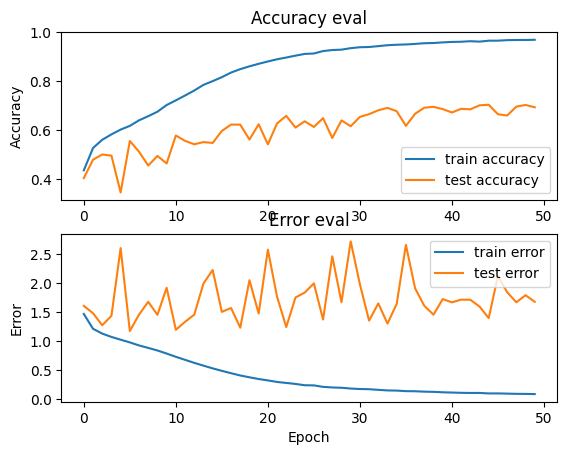

In [132]:
# plot accuracy/error for training and validation
plot_history(history)

In [133]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

305/305 - 3s - loss: 1.6741 - accuracy: 0.6936 - 3s/epoch - 9ms/step

Test accuracy: 0.6936279535293579


In [74]:
#Model 4 CNN
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D((1)))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=0.00001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 180, 128)          512       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 180, 128)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 178, 256)          98560     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 178, 256)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 176, 512)          393728    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 176, 512)        

In [76]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/50
274/274 [==============================] - 42s 154ms/step - loss: 1.6213 - accuracy: 0.3530 - val_loss: 1.4476 - val_accuracy: 0.4473
Epoch 2/50
274/274 [==============================] - 42s 152ms/step - loss: 1.4832 - accuracy: 0.4205 - val_loss: 1.3523 - val_accuracy: 0.4830
Epoch 3/50
274/274 [==============================] - 42s 152ms/step - loss: 1.4134 - accuracy: 0.4505 - val_loss: 1.3020 - val_accuracy: 0.4990
Epoch 4/50
274/274 [==============================] - 42s 152ms/step - loss: 1.3663 - accuracy: 0.4692 - val_loss: 1.2561 - val_accuracy: 0.5128
Epoch 5/50
274/274 [==============================] - 42s 152ms/step - loss: 1.3219 - accuracy: 0.4854 - val_loss: 1.2388 - val_accuracy: 0.5170
Epoch 6/50
274/274 [==============================] - 42s 152ms/step - loss: 1.2903 - accuracy: 0.4968 - val_loss: 1.2064 - val_accuracy: 0.5329
Epoch 7/50
274/274 [==============================] - 42s 152ms/step - loss: 1.2676 - accuracy: 0.5047 - val_loss: 1.1936 - val_ac

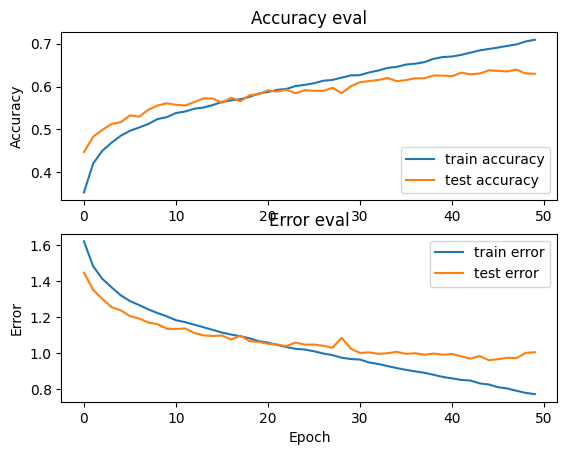

In [77]:
# plot accuracy/error for training and validation
plot_history(history)

In [78]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(x_test, y_test,verbose=2)
print('\nTest accuracy:', test_acc)

305/305 - 4s - loss: 0.9383 - accuracy: 0.6517 - 4s/epoch - 14ms/step

Test accuracy: 0.6516957879066467


In [74]:
#CNN model 5
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1,padding="same", activation="relu",input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])


In [70]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 10,
                              restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)



In [75]:
EPOCHS = 50
batch_size = 64

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/50
548/548 [==============================] - 93s 162ms/step - loss: 1.5000 - acc: 0.4320 - val_loss: 1.7627 - val_acc: 0.2749 - lr: 0.0010
Epoch 2/50
548/548 [==============================] - 88s 160ms/step - loss: 1.2379 - acc: 0.5198 - val_loss: 1.7943 - val_acc: 0.3649 - lr: 0.0010
Epoch 3/50
548/548 [==============================] - 88s 160ms/step - loss: 1.1576 - acc: 0.5488 - val_loss: 1.6022 - val_acc: 0.4106 - lr: 0.0010
Epoch 4/50
548/548 [==============================] - 88s 160ms/step - loss: 1.0996 - acc: 0.5733 - val_loss: 1.2862 - val_acc: 0.5077 - lr: 0.0010
Epoch 5/50
548/548 [==============================] - 88s 160ms/step - loss: 1.0510 - acc: 0.5903 - val_loss: 1.5122 - val_acc: 0.4728 - lr: 0.0010
Epoch 6/50
548/548 [==============================] - 88s 160ms/step - loss: 1.0060 - acc: 0.6073 - val_loss: 1.2299 - val_acc: 0.5357 - lr: 0.0010
Epoch 7/50
548/548 [==============================] - 88s 160ms/step - loss: 0.9641 - acc: 0.6264 - val_loss: 1.

In [61]:
#model RNN
# Define the LSTM model
def create_model_LSTM():
    model = Sequential()
    model.add(keras.layers.LSTM(1024, return_sequences=True, input_shape=(182, 1)))
    model.add(keras.layers.LSTM(512))

    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(7, activation='softmax'))

    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["acc", f1_m])
    return model

In [62]:
### train using LSTM model
model_RNN1 = create_model_LSTM()

In [63]:
history_RNN1 = model_RNN1.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=100,shuffle=True)

Epoch 1/100
548/548 [==============================] - 128s 222ms/step - loss: 1.8798 - acc: 0.1993 - f1_m: 0.0033 - val_loss: 1.8295 - val_acc: 0.2199 - val_f1_m: 0.0000e+00
Epoch 2/100
548/548 [==============================] - 122s 223ms/step - loss: 1.8363 - acc: 0.2322 - f1_m: 0.0000e+00 - val_loss: 1.8278 - val_acc: 0.2359 - val_f1_m: 0.0000e+00
Epoch 3/100
548/548 [==============================] - 122s 223ms/step - loss: 1.8623 - acc: 0.2072 - f1_m: 0.0000e+00 - val_loss: 1.8978 - val_acc: 0.1683 - val_f1_m: 0.0000e+00
Epoch 4/100
548/548 [==============================] - 122s 223ms/step - loss: 1.8064 - acc: 0.2436 - f1_m: 0.0079 - val_loss: 1.7216 - val_acc: 0.2927 - val_f1_m: 0.0000e+00
Epoch 5/100
548/548 [==============================] - 123s 224ms/step - loss: 1.7334 - acc: 0.2870 - f1_m: 0.0219 - val_loss: 1.7165 - val_acc: 0.2906 - val_f1_m: 0.0220
Epoch 6/100
548/548 [==============================] - 122s 223ms/step - loss: 1.7088 - acc: 0.3011 - f1_m: 0.0611 - val_

KeyboardInterrupt: 

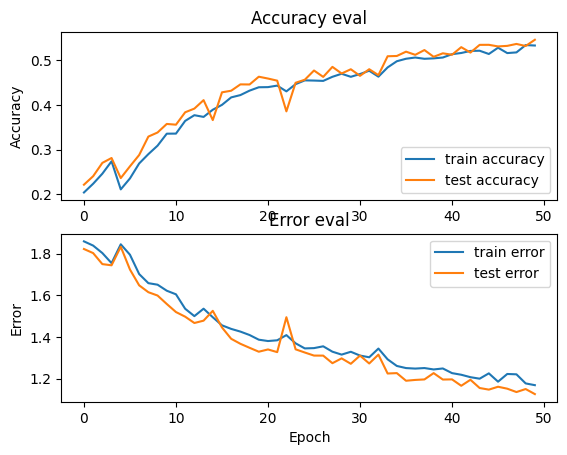

In [76]:
# plot accuracy/error for training and validation
plot_history(history_RNN1)

In [77]:
# evaluate model on test set
test_loss, test_acc = model_RNN1.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

305/305 - 2s - loss: 1.1266 - accuracy: 0.5460 - 2s/epoch - 6ms/step

Test accuracy: 0.5460431575775146
